In [65]:
import numpy as np
np.random.seed(0)
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.palettes import Category20
from bokeh.models import Label
from bokeh.layouts import gridplot
colors = Category20[20]
output_notebook()

from risk_functions import Simulate_Price_Black_Scholes, Delta_Computation, Black_Scholes_Formula

Loading BokehJS ...

# Définition des paramètres

In [2]:
F0 = 100. # Prix initial du forward en euros/MWh
K = 100. # Prix d'exercice de l'option en euros/MWh
mu = 0.05 # tendance moyenne de l'actif en %/year
sigma = 0.2 # volatilité en %/year
r = 0. # Taux sans risque en %/year
Q = 10 # Quantité produite à T en tonne

Nb_simulations = 10000

# Horizon de simulation
date_start = '01/01/2025 00:00'
date_end = '31/12/2025 23:00' # Egal à la date finale T
Frequency = 'D' # 'D': jour, 'h': heure : fréquence de simulation
Datelist = pd.date_range(start=date_start, end=date_end, freq=Frequency).tolist() # Liste des dates de simulation
Diff_date = Datelist[1] - Datelist[0] # Calcul du pas de temps "dt"
Nb_seconds_in_year = 365*24*3600 #Nombre de secondes dans une année
dt = Diff_date.total_seconds()/Nb_seconds_in_year # Calcul de la valeur du pas de temps en secondes
simulation_horizon = (Datelist[-1]-Datelist[0]).total_seconds()/Nb_seconds_in_year # Horizon de simulation (en années)

# Estimation des cash-flows avec une réduction optimale du risque en utilisant la formule fermée de Black-Scholes
(mu est remplacé par r)

In [3]:
# On estime la valeur des cash-flows après couverture
nominal_value_t0 = Black_Scholes_Formula(vol = sigma, risk_free_rate = r, current_price = F0, strike = K, maturity = simulation_horizon)
estimated_hedged_cash_flow = Q * nominal_value_t0

# Comparaison des valeurs (Monte Carlo avec mu = r et la formule de Black-Scholes)
print('Cash-flows estimés avec une reduction optimale du risque: ')
print(estimated_hedged_cash_flow)


Cash-flows estimés avec une reduction optimale du risque: 
79.54684509454552


# Estimation des cash-flows avec une réduction optimale du risque par une approche de Monte Carlo

## 1) Simulation des prix forward

Espérance des Cash-flows de la production:
109.11764542752097


Text(0.5, 1.0, 'Distribution des cash-flows finaux')

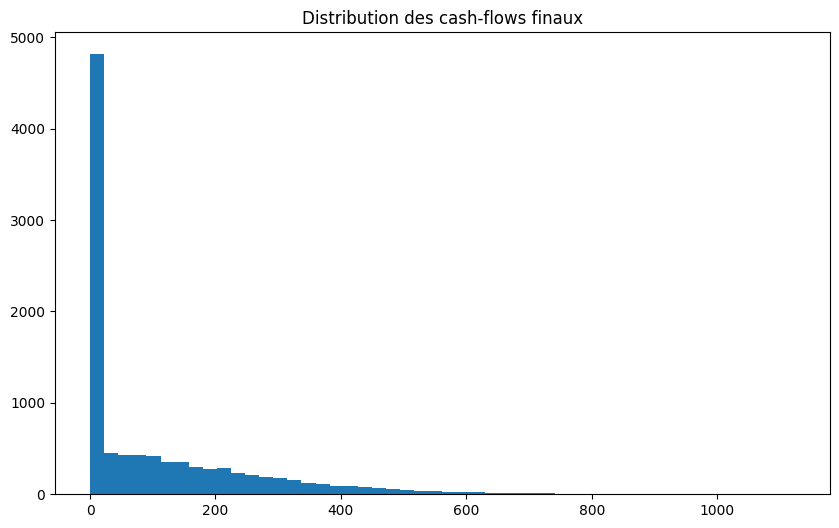

In [34]:
# Simulation du prix forward (a partir de la formule de diffusion du modèle de Black-Scholes)
np.random.seed(0)
F = Simulate_Price_Black_Scholes(initial_value = F0, tendency=mu, volatility=sigma, nb_simulations = Nb_simulations, Horizon=simulation_horizon, dt=dt)

# Calcul des cash-flows espérés de la production
production_cash_flow = Q * np.maximum(F[:,-1]-K , 0)
mean_production_cash_flow = np.mean(production_cash_flow)
print('Espérance des Cash-flows de la production:')
print(mean_production_cash_flow)
plt.figure()
plt.hist(production_cash_flow, bins = 50)
plt.title("Distribution des cash-flows finaux")


# 2) Application de la couverture 

In [42]:
### Initialisation des différents tableaux
Delta = np.zeros_like(F) # Delta de l'option nominale
hedging_quantity = np.zeros_like(F) # (Couverture) Quantité à acheter ou vendre (= - Q * Delta)
hedging_cash_flow = np.zeros_like(F) # Cash-flows générés par les actions de couverture
production_mark_to_market = np.zeros_like(F) # "valeur" courante de la production future 

for i,d in enumerate(Datelist[:-1]):
    # Calcul du prix de l'option (Black-Scholes formula) et du Delta
    maturity = (Datelist[-1]-d).total_seconds()/Nb_seconds_in_year
    
    # Calcul du volume à entrer dans le contrat forward actuel
    Delta = Delta_Computation(vol = sigma, risk_free_rate = r, current_price = F[:, i], strike = K, maturity = maturity)     
    hedging_quantity[:, i] = - Q * Delta 
    
    # Calcul de la "valeur" courante de la future production
    nominal_value = Black_Scholes_Formula(vol = sigma, risk_free_rate = r, current_price = F[:, i], strike = K, maturity = maturity)
    production_mark_to_market[:,i] = Q * nominal_value

    # Résultat des cash-flows de la position de couverture
    hedging_cash_flow[:, i] = hedging_quantity[:, i - 1] * (F[:, i] - F[:, i - 1])  

# A date T, la valeur de la production est égale au cash-flow
production_mark_to_market[:,-1] = production_cash_flow

# Valeur des cash-flows cumulés des actions de couverture effectuées
hedging_sum_cash_flow = np.sum(hedging_cash_flow, axis=1)

# Valeur cumulée des cash-flows de couverture
cumulated_hedging_cash_flow = np.cumsum(hedging_cash_flow, axis=1)


## 3) Affichage des résultats

Moyenne des Cash-flows de la production couverte:
79.54847343544519


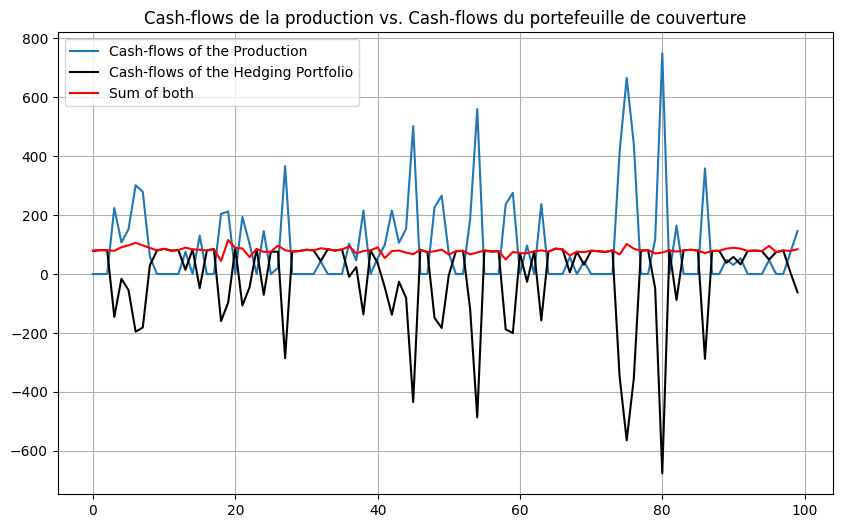

In [43]:
# Moyenne des cash-flows du protefeuille global (= Production + portefeuille de couverture)
mean_total_cash_flow = np.mean(production_cash_flow + hedging_sum_cash_flow)
print('Moyenne des Cash-flows de la production couverte:')
print(mean_total_cash_flow)

# Cash-flows de la production vs. Cash-flows du portefeuille de couverture
plt.figure()
plt.plot(production_cash_flow[:100])
plt.plot(hedging_sum_cash_flow[:100], 'k')
plt.plot(production_cash_flow[:100] + hedging_sum_cash_flow[:100], 'r')
plt.title('Cash-flows de la production vs. Cash-flows du portefeuille de couverture')
plt.legend(['Cash-flows of the Production','Cash-flows of the Hedging Portfolio' ,'Sum of both' ])
plt.grid()
plt.show()

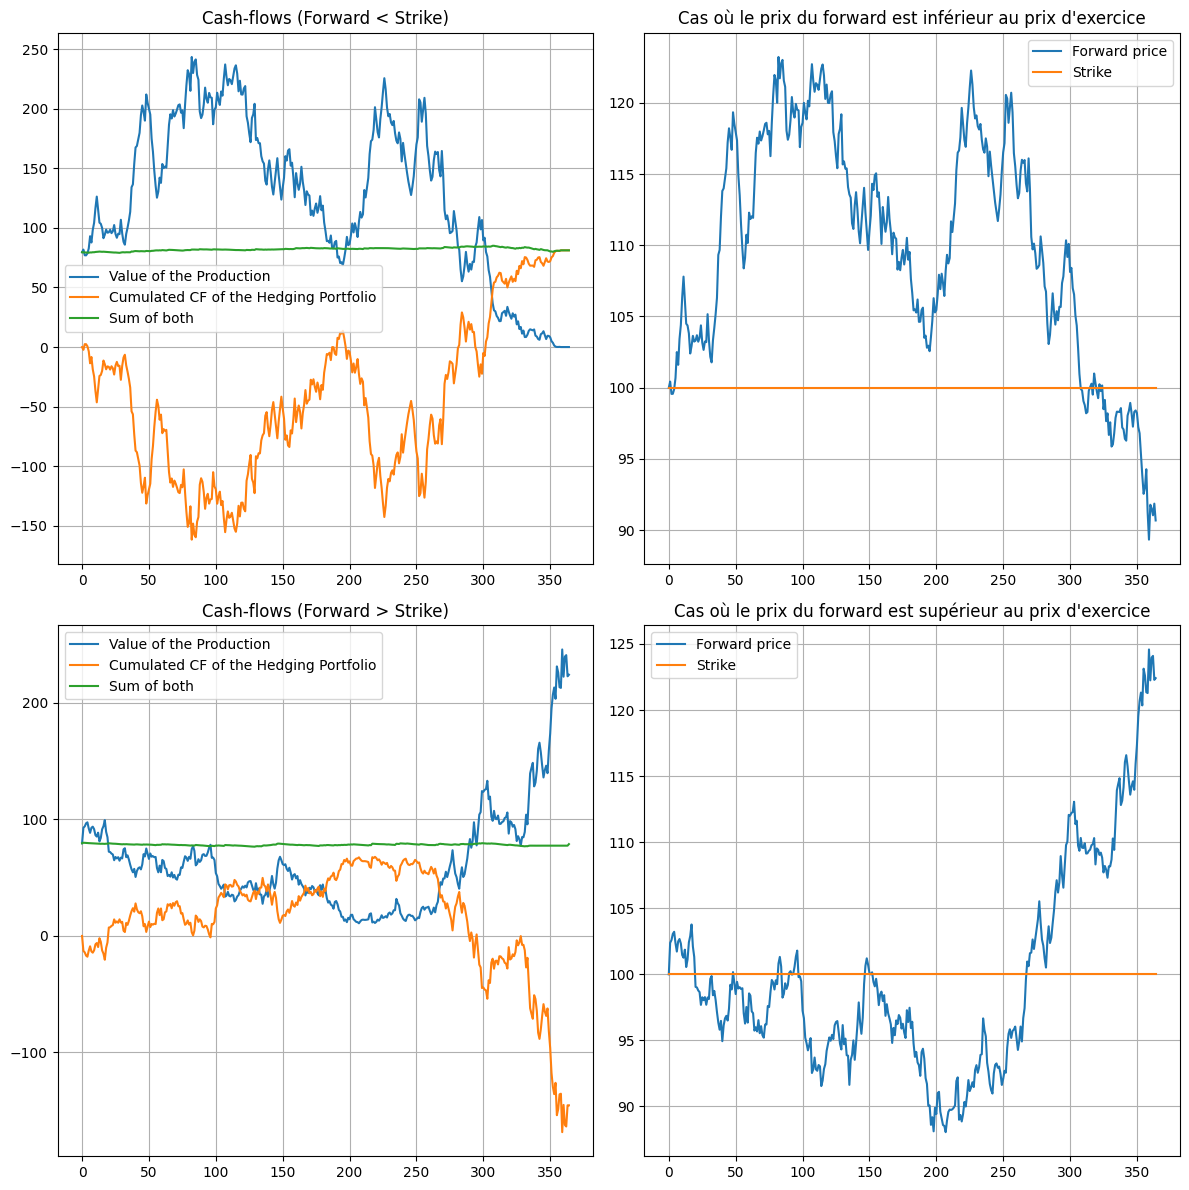

In [40]:
# Création de la figure avec des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Cas ou le prix du forward est inférieur au prix d'exercice (i.e. la production donnera 0 cash-flows)
I = 1
axes[0, 0].plot(production_mark_to_market[I, :])
axes[0, 0].plot(cumulated_hedging_cash_flow[I, :])
axes[0, 0].plot(production_mark_to_market[I, :] + cumulated_hedging_cash_flow[I, :])
axes[0, 0].legend(['Value of the Production', 'Cumulated CF of the Hedging Portfolio', 'Sum of both'])
axes[0, 0].grid()
axes[0, 0].set_title('Cash-flows (Forward < Strike)')

axes[0, 1].plot(F[I, :])
axes[0, 1].plot(K * np.ones(len(F[I, :])))
axes[0, 1].legend(['Forward price', 'Strike'])
axes[0, 1].set_title("Cas où le prix du forward est inférieur au prix d'exercice")
axes[0, 1].grid()

# Cas où le prix du forward est supérieur au prix d'exercice
I = 3
axes[1, 0].plot(production_mark_to_market[I, :])
axes[1, 0].plot(cumulated_hedging_cash_flow[I, :])
axes[1, 0].plot(production_mark_to_market[I, :] + cumulated_hedging_cash_flow[I, :])
axes[1, 0].legend(['Value of the Production', 'Cumulated CF of the Hedging Portfolio', 'Sum of both'])
axes[1, 0].grid()
axes[1, 0].set_title('Cash-flows (Forward > Strike)')

axes[1, 1].plot(F[I, :])
axes[1, 1].plot(K * np.ones(len(F[I, :])))
axes[1, 1].legend(['Forward price', 'Strike'])
axes[1, 1].set_title("Cas où le prix du forward est supérieur au prix d'exercice")
axes[1, 1].grid()

plt.tight_layout()
plt.show()

In [97]:
# Moyenne des cash-flows du protefeuille non couvert (= Production)
mean_total_cash_flow_non_hedged = np.mean(production_cash_flow)
print('Moyenne des Cash-flows de la production non couverte:')
print(mean_total_cash_flow_non_hedged)

# Moyenne des cash-flows du protefeuille couvert (= Production + portefeuille de couverture)
mean_total_cash_flow_hedged = np.mean(production_cash_flow + hedging_sum_cash_flow)
print('Moyenne des Cash-flows de la production couverte:')
print(mean_total_cash_flow)

fig1 = figure(title=f'Histogramme des cash-flows sans couverture; Moyenne = {round(Q*mean_total_cash_flow_non_hedged,2)}', x_axis_label='Cash Flow', y_axis_label='Frequency', width=1000, height=400)
fig2 = figure(title=f'Histogramme des cash-flows avec couverture; Moyenne = {round(Q*mean_total_cash_flow_hedged,2)}', x_axis_label='Cash Flow', y_axis_label='Frequency', width=1000, height=400)

hist_hedged, edges_hedged = np.histogram(production_cash_flow, density=True, bins=50)
hist_non_hedged, edges_non_hedge = np.histogram(production_cash_flow + hedging_sum_cash_flow, density=True, bins=50)

cash_flows_hist_non_hedged = fig1.quad(top=hist_non_hedged, bottom=0, left=edges_non_hedge[:-1], right=edges_non_hedge[1:], line_color="black")
cash_flows_hist_hedged = fig2.quad(top=hist_hedged, bottom=0, left=edges_hedged[:-1], right=edges_hedged[1:], line_color="black")

average_non_hedged = fig1.line([mean_total_cash_flow_non_hedged, mean_total_cash_flow_non_hedged], [0, max(hist_hedged)], line_color='red', line_dash='dashed', line_width=2, legend_label='Average')
average_hedged = fig2.line([mean_total_cash_flow_hedged, mean_total_cash_flow_hedged], [0, max(hist_non_hedged)], line_color='red', line_dash='dashed', line_width=2, legend_label='Average')

grid = gridplot([[fig1], [fig2]])
show(grid, notebook_handle=True)

def update_hist(initial_value, tendency, volatility, prod_cost, volume):
    simulated_prices = Simulate_Price_Black_Scholes(initial_value, tendency, volatility, 10000)
    S_T = simulated_prices[:,-1]
    production_cash_flow = volume*np.maximum(S_T - prod_cost, 0)
    mean_total_cash_flow_non_hedged = np.mean(production_cash_flow)

    for i,d in enumerate(Datelist[:-1]):
        # Calcul du prix de l'option (Black-Scholes formula) et du Delta
        maturity = (Datelist[-1]-d).total_seconds()/Nb_seconds_in_year
        
        # Calcul du volume à entrer dans le contrat forward actuel
        Delta = Delta_Computation(vol = volatility, risk_free_rate = r, current_price = simulated_prices[:, i], strike = prod_cost, maturity = maturity)     
        hedging_quantity[:, i] = - volume * Delta 

        # Résultat des cash-flows de la position de couverture
        hedging_cash_flow[:, i] = hedging_quantity[:, i - 1] * (simulated_prices[:, i] - simulated_prices[:, i - 1])  

    # Valeur des cash-flows cumulés des actions de couverture effectuées
    hedging_sum_cash_flow = np.sum(hedging_cash_flow, axis=1)
    mean_total_cash_flow_hedged = np.mean(production_cash_flow + hedging_sum_cash_flow)

    hist_non_hedged, edges_non_hedged = np.histogram(production_cash_flow, density=True, bins=50)
    hist_hedged, edges_hedged = np.histogram(production_cash_flow + hedging_sum_cash_flow, density=True, bins=50)
    
    cash_flows_hist_non_hedged.data_source.data['top'] = hist_non_hedged
    cash_flows_hist_non_hedged.data_source.data['left'] = edges_non_hedged[:-1]
    cash_flows_hist_non_hedged.data_source.data['right'] = edges_non_hedged[1:]
    fig1.title.text = f'Histogramme des cash-flows sans couverture; Moyenne = {round(Q*mean_total_cash_flow_non_hedged,2)}'

    cash_flows_hist_hedged.data_source.data['top'] = hist_hedged
    cash_flows_hist_hedged.data_source.data['left'] = edges_hedged[:-1]
    cash_flows_hist_hedged.data_source.data['right'] = edges_hedged[1:]
    fig2.title.text = f'Histogramme des cash-flows avec couverture; Moyenne = {round(Q*mean_total_cash_flow_hedged,2)}'
    

    #Update average
    average_non_hedged.data_source.data['x'] = [mean_total_cash_flow_non_hedged, mean_total_cash_flow_non_hedged]
    average_non_hedged.data_source.data['y'] = [0, max(hist_non_hedged)]

    average_hedged.data_source.data['x'] = [mean_total_cash_flow_hedged, mean_total_cash_flow_hedged]
    average_hedged.data_source.data['y'] = [0, max(hist_hedged)]
    
    push_notebook()

interact(update_hist, initial_value=(0,300,10), tendency=(-1,2,0.01), volatility=(0.01,1,0.01), prod_cost=(0.1,200,10), volume=(1,200,10))


Moyenne des Cash-flows de la production non couverte:
109.11764542752097
Moyenne des Cash-flows de la production couverte:
79.54847343544519


interactive(children=(IntSlider(value=150, description='initial_value', max=300, step=10), FloatSlider(value=0…

<function __main__.update_hist(initial_value, tendency, volatility, prod_cost, volume)>

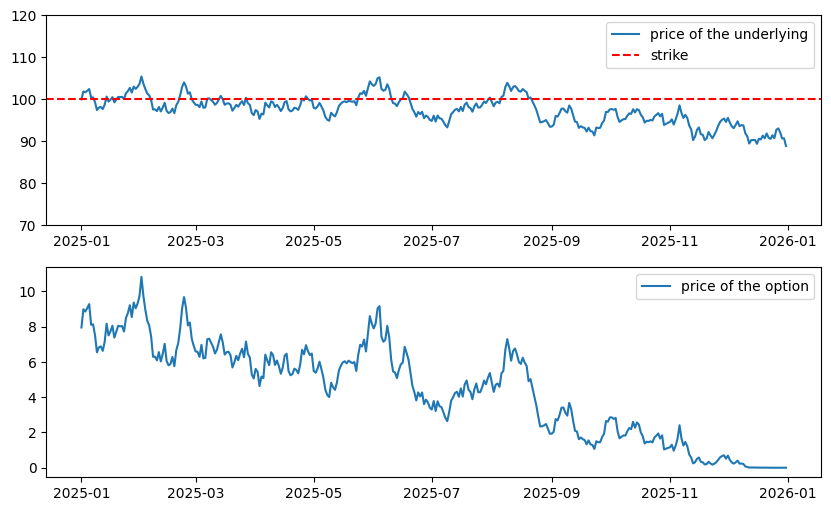

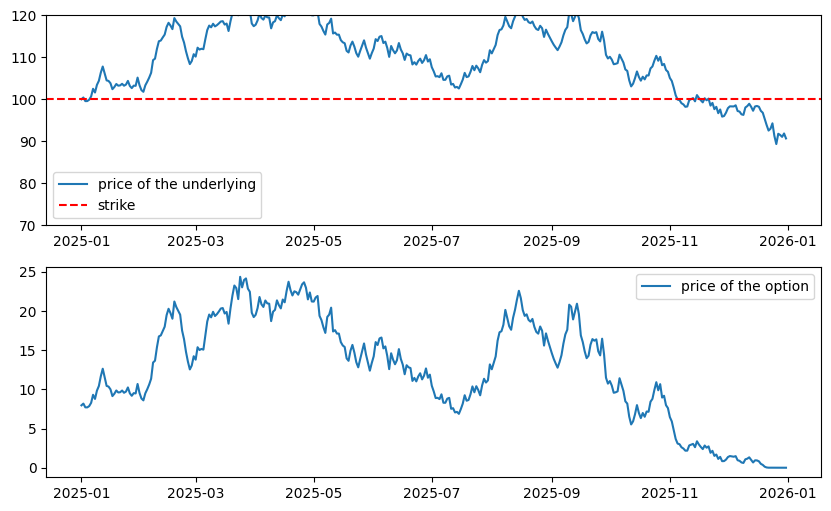

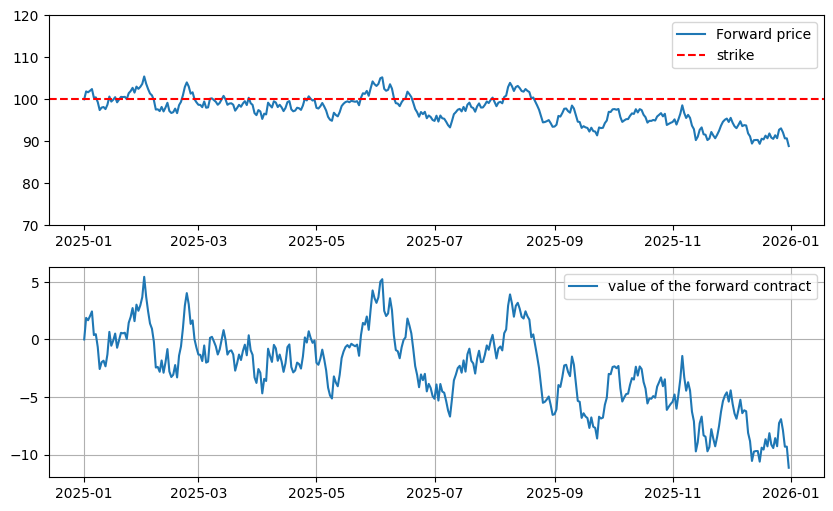

In [98]:
i=0
plt.subplot(211)
plt.plot(Datelist, F[i,:],label='price of the underlying')
plt.axhline(y=K, color='r', linestyle='--', label = "strike")  # Ajouter une ligne rouge pointillée 
plt.ylim([70,120])
plt.legend()
plt.subplot(212)
plt.plot(Datelist,production_mark_to_market[i,:]/Q, label = "price of the option")
plt.legend()
plt.show()

i=1
plt.subplot(211)
plt.plot(Datelist, F[i,:],label='price of the underlying')
plt.axhline(y=K, color='r', linestyle='--', label = "strike")  # Ajouter une ligne rouge pointillée 
plt.ylim([70,120])
plt.legend()
plt.subplot(212)
plt.plot(Datelist,production_mark_to_market[i,:]/Q, label = "price of the option")
plt.legend()
plt.show()

i=0
plt.subplot(211)
plt.plot(Datelist, F[i,:],label='Forward price')
plt.axhline(y=K, color='r', linestyle='--', label = "strike")  # Ajouter une ligne rouge pointillée 
plt.ylim([70,120])

plt.legend()
plt.subplot(212)
plt.plot(Datelist,F[i,:]-F0, label = "value of the forward contract")
plt.legend()
plt.grid()
plt.show()